In [1]:
import scipy.io as io
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
from torch.optim import lr_scheduler
from util.misc import AverageMeter
from util.misc import mkdirs, to_device
from util.visualize import visualize_network_output
from util.summary import LogSummary
from datetime import datetime
import time

# datasets
from dataset.data_util import pil_load_img
from dataset.dataload import TextInstance, TextDataset
import torch.utils.data as data
from dataset.total_text import TotalText
from dataset.synth_text import SynthText
from util.config import config as cfg, update_config, print_config

# models
from models import TextNet

# Losses
from loss import TextLoss

In [2]:
# 学習の設定
dataset = "total-text"
LoadWeights = False
original = False # 論文と同等のネットワークか
resnet = True
batch_size = cfg.batch_size
train_step = 0

# define backbone_name for model save+load
if original:
    backbone_name = "vgg16-original"
else:
    backbone_name = "vgg16"
if resnet:
    backbone_name = "resnet50"

# Load path
WeightPath = "weights/totaltext/textsnake_{}_30.pth".format(backbone_name)

In [3]:
# logger
log_dir = os.path.join(cfg.log_dir, datetime.now().strftime('%b%d_%H-%M-%S_') + cfg.exp_name)
logger = LogSummary(log_dir)

In [4]:
# Define model
if resnet:
    model = TextNet(original=original, backbone="resnet50")
else:
    model = TextNet(original=original)

# Cuda?
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    cudnn.benchmark = True
model.to(device)

# Load weights if required
if LoadWeights:
    model.load_state_dict(torch.load(WeightPath)['model'])

In [5]:
# Data augumentationの設定。
"""
Images are randomly rotated, and cropped with areas ranging from 0.24 to 1.69
and aspect ratios ranging from 0.33 to 3. After that, noise, blur, and lightness
are randomly adjusted. We ensure that the text on the augmented images are
still legible, if they are legible before augmentation.

→ crop areaの設定を論文に忠実になるように変更
"""
from util.augmentation import BaseTransform, Augmentation
# 論文の通りrandom resize scale(0.24~1.69) aspect(0.33~3)、Mirror flip,, random rotation, 
# lighting noiseを付加

In [6]:
# Define dataset
# 最初にSynthTextで1 epoch学習し、その重みを元にTotalTextでFinetuneする。
if dataset == 'total-text':
    # Train with augumentations.
    trainset = TotalText(
        data_root='data/total-text',
        ignore_list=None,
        is_training=True,
        transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
    # Validation時にはaugumentationはせず、normalizeとresizeのみ。
    valset = TotalText(
        data_root='data/total-text',
        ignore_list=None,
        is_training=False,
        transform=BaseTransform(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
    
elif dataset == 'synth-text':
    # Synthtextはtrainingのみ.
    trainset = SynthText(
        data_root='data/SynthText',
        is_training=True,
        transform=Augmentation(size=cfg.input_size, mean=cfg.means, std=cfg.stds)
    )
    valset = None
    
else:
    raise NotImplementedError(dataset)
    
# Define loaders
train_loader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True, num_workers=8)
if dataset == "total-text":
    val_loader = torch.utils.data.DataLoader(valset,batch_size=batch_size, num_workers=8)

可視化してaugumentationが上手く適応できているか確認

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


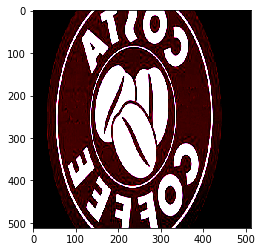

tcl_mask


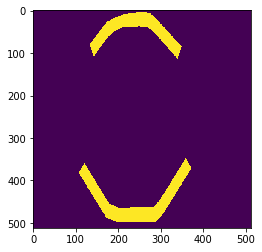

radius_map


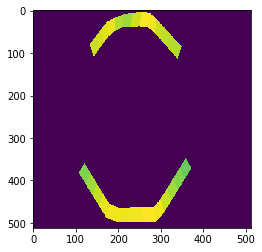

sin_map


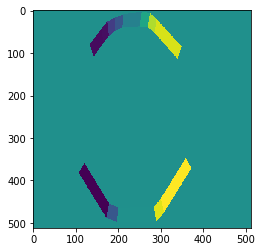

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


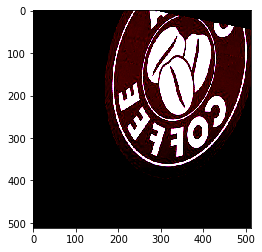

tcl_mask


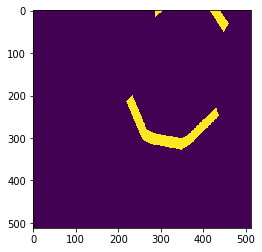

radius_map


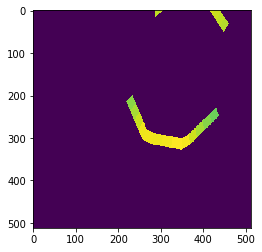

sin_map


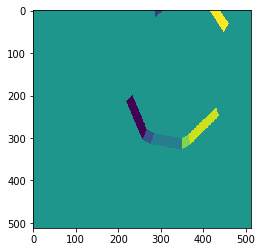

show imgs


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


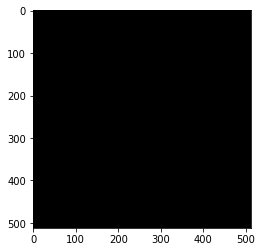

tcl_mask


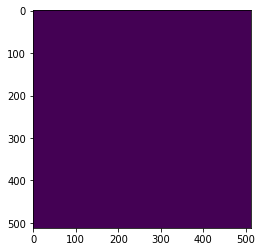

radius_map


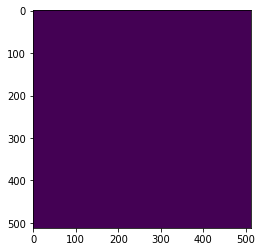

sin_map


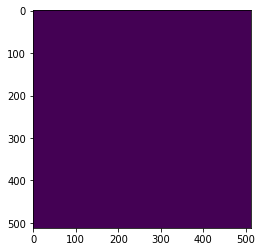

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


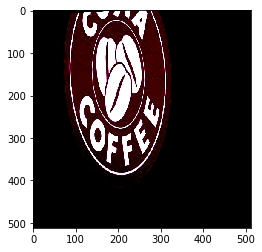

tcl_mask


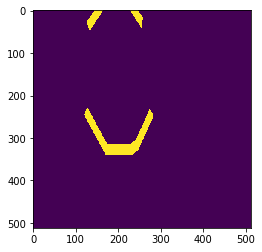

radius_map


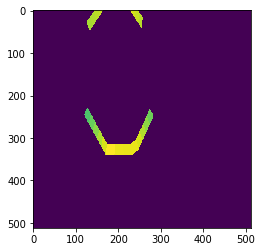

sin_map


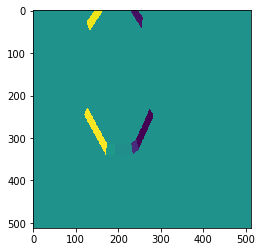

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


show imgs


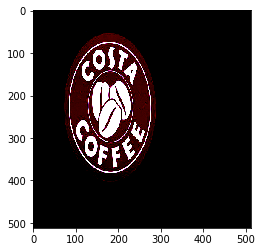

tcl_mask


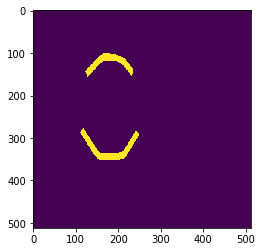

radius_map


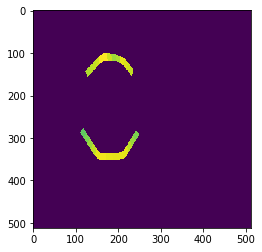

sin_map


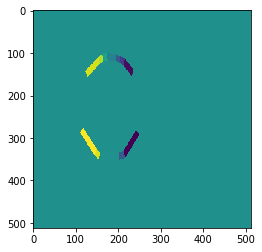

In [7]:
for i in range(5):
    # show some images
    image, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta = trainset[0]
    print("show imgs")
    plt.imshow(image.transpose([1,2,0]))
    plt.show()
    print("tcl_mask")
    plt.imshow(tcl_mask)
    plt.show()
    print("radius_map")
    plt.imshow(radius_map)
    plt.show()
    print("sin_map")
    plt.imshow(sin_map)
    plt.show()

# Define Loss and optimizer

In [8]:
# コード解説はloss.pyに記載
criterion = TextLoss()

In [9]:
"""
We adopt the Adam optimazer [41] as our learning rate scheme. During the pre-training stage,
the learning rate is fixed to 10−3. During the fine-tuning stage, the learing rate is
set to 10−3 initially and decaies with a rate of 0.8 every 5000 iterations.
"""
# AdamとStepLRschedulerを使用。
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2500, gamma=0.8)

# Trainingを定義

In [10]:
# モデル保存の便利関数を流用
def save_model(model, epoch, lr, optimzer):
    save_dir = os.path.join(cfg.save_dir, cfg.exp_name)
    if not os.path.exists(save_dir):
        mkdirs(save_dir)

    save_path = os.path.join(save_dir, 'textsnake_{}_{}.pth'.format(backbone_name, epoch))
    print('Saving to {}.'.format(save_path))
    state_dict = {
        'lr': lr,
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimzer.state_dict()
    }
    torch.save(state_dict, save_path)

In [11]:
def train(model, train_loader, criterion, scheduler, optimizer, epoch, logger):
    global train_step
    losses = AverageMeter()
    batch_time = AverageMeter()
    data_time = AverageMeter()
    end = time.time()
    model.train()
    scheduler.step()
    
    print('Epoch: {} : LR = {}'.format(epoch, optimizer.state_dict()['param_groups'][0]['lr']))

    for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(train_loader):
        data_time.update(time.time() - end)

        train_step += 1
        # Cudaへ
        img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)
        
        # 画像を入力しpredictionを元にロス計算
        output = model(img)
        tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
            criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
        
        # 論文ではそれぞれのロスに重み付けをしていない
        # >The weights constants λ1, λ2, λ3, λ4 and λ5 are all set to 1 in our experiments.
        loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

        # スケジューラを更新
        if dataset=="total-text":
            scheduler.step()
            
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()    
        
        # トラッカー更新。便利なのでそのまま使った。
        losses.update(loss.item())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if cfg.viz and i % cfg.viz_freq == 0:
            visualize_network_output(output, tr_mask, tcl_mask, mode='train')

        if i % cfg.display_freq == 0:
            print('({:d} / {:d}) - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                i, len(train_loader), loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(), cos_loss.item(), radii_loss.item())
            )

        if i % cfg.log_freq == 0:
            logger.write_scalars({
                'loss': loss.item(),
                'tr_loss': tr_loss.item(),
                'tcl_loss': tcl_loss.item(),
                'sin_loss': sin_loss.item(),
                'cos_loss': cos_loss.item(),
                'radii_loss': radii_loss.item()
            }, tag='train', n_iter=train_step)
            
        if dataset == "synth-text" and i%1000 == 0:
            save_model(model, epoch, scheduler.get_lr(), optimizer)
            
    if epoch % 10 == 0:
        save_model(model, epoch, scheduler.get_lr(), optimizer)

    print('Training Loss: {}'.format(losses.avg))

# Validationを定義。ほぼtrainと同様。

In [12]:
def validation(model, valid_loader, criterion, epoch, logger):
    # gradを計算しないことでメモリ節約、高速化
    with torch.no_grad():
        model.eval()
        losses = AverageMeter()
        tr_losses = AverageMeter()
        tcl_losses = AverageMeter()
        sin_losses = AverageMeter()
        cos_losses = AverageMeter()
        radii_losses = AverageMeter()

        for i, (img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map, meta) in enumerate(valid_loader):

            img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map = to_device(
                img, train_mask, tr_mask, tcl_mask, radius_map, sin_map, cos_map)

            output = model(img)

            tr_loss, tcl_loss, sin_loss, cos_loss, radii_loss = \
                criterion(output, tr_mask, tcl_mask, sin_map, cos_map, radius_map, train_mask)
            loss = tr_loss + tcl_loss + sin_loss + cos_loss + radii_loss

            # update losses
            losses.update(loss.item())
            tr_losses.update(tr_loss.item())
            tcl_losses.update(tcl_loss.item())
            sin_losses.update(sin_loss.item())
            cos_losses.update(cos_loss.item())
            radii_losses.update(radii_loss.item())

            if cfg.viz and i % cfg.viz_freq == 0:
                visualize_network_output(output, tr_mask, tcl_mask, mode='val')

            if i % cfg.display_freq == 0:
                print(
                    'Validation: - Loss: {:.4f} - tr_loss: {:.4f} - tcl_loss: {:.4f} - sin_loss: {:.4f} - cos_loss: {:.4f} - radii_loss: {:.4f}'.format(
                        loss.item(), tr_loss.item(), tcl_loss.item(), sin_loss.item(),
                        cos_loss.item(), radii_loss.item())
                )

        logger.write_scalars({
            'loss': losses.avg,
            'tr_loss': tr_losses.avg,
            'tcl_loss': tcl_losses.avg,
            'sin_loss': sin_losses.avg,
            'cos_loss': cos_losses.avg,
            'radii_loss': radii_losses.avg
        }, tag='val', n_iter=epoch)

        print('Validation Loss: {}'.format(losses.avg))


# 学習ループ開始

In [ ]:
print('Start training TextSnake.')
import warnings
import gc
warnings.simplefilter('ignore')

if dataset == "synth-text":
    end_epoch=1
else:
    end_epoch =  cfg.max_epoch

for epoch in range(cfg.start_epoch, end_epoch):
    train(model, train_loader, criterion, scheduler, optimizer, epoch, logger)
    if valset:
        validation(model, val_loader, criterion, epoch, logger)
    # ループ後にメモリ解放
    torch.cuda.empty_cache()
    gc.collect()

Start training TextSnake.
Epoch: 0 : LR = 0.001
(0 / 157) - Loss: 2.7062 - tr_loss: 0.7425 - tcl_loss: 0.6927 - sin_loss: 0.5019 - cos_loss: 0.2709 - radii_loss: 0.4982
(100 / 157) - Loss: 2.0658 - tr_loss: 0.5186 - tcl_loss: 0.5639 - sin_loss: 0.1340 - cos_loss: 0.0915 - radii_loss: 0.7577
Saving to weights/totaltext/textsnake_resnet50_0.pth.
Training Loss: 2.1638556521409638
Validation: - Loss: 2.7595 - tr_loss: 0.8825 - tcl_loss: 0.7497 - sin_loss: 0.1608 - cos_loss: 0.0983 - radii_loss: 0.8682
Validation Loss: 2.8421347454974524
Epoch: 1 : LR = 0.001
(0 / 157) - Loss: 2.3023 - tr_loss: 0.5155 - tcl_loss: 0.5744 - sin_loss: 0.1798 - cos_loss: 0.0452 - radii_loss: 0.9874
(100 / 157) - Loss: 1.8555 - tr_loss: 0.4929 - tcl_loss: 0.5740 - sin_loss: 0.1698 - cos_loss: 0.1261 - radii_loss: 0.4928
Training Loss: 2.007013150840808
Validation: - Loss: 2.0550 - tr_loss: 0.4697 - tcl_loss: 0.5376 - sin_loss: 0.0828 - cos_loss: 0.0963 - radii_loss: 0.8687
Validation Loss: 2.1011481630174735
Epo

Training Loss: 1.5352238819098016
Validation: - Loss: 1.6014 - tr_loss: 0.2399 - tcl_loss: 0.3508 - sin_loss: 0.0408 - cos_loss: 0.1030 - radii_loss: 0.8669
Validation Loss: 1.6642612407082005
Epoch: 18 : LR = 0.0008
(0 / 157) - Loss: 1.8556 - tr_loss: 0.4192 - tcl_loss: 0.3956 - sin_loss: 0.0526 - cos_loss: 0.1076 - radii_loss: 0.8805
(100 / 157) - Loss: 1.4084 - tr_loss: 0.3838 - tcl_loss: 0.3380 - sin_loss: 0.0355 - cos_loss: 0.0706 - radii_loss: 0.5804
Training Loss: 1.5469007378171205
Validation: - Loss: 1.5839 - tr_loss: 0.2363 - tcl_loss: 0.3360 - sin_loss: 0.0434 - cos_loss: 0.1008 - radii_loss: 0.8674
Validation Loss: 1.654434323310852
Epoch: 19 : LR = 0.0008
(0 / 157) - Loss: 1.2898 - tr_loss: 0.2396 - tcl_loss: 0.3630 - sin_loss: 0.0307 - cos_loss: 0.1474 - radii_loss: 0.5091
(100 / 157) - Loss: 1.7099 - tr_loss: 0.3375 - tcl_loss: 0.3680 - sin_loss: 0.0329 - cos_loss: 0.2065 - radii_loss: 0.7652
Training Loss: 1.5632331644653514
Validation: - Loss: 1.6011 - tr_loss: 0.2466 

(0 / 157) - Loss: 1.8156 - tr_loss: 0.2353 - tcl_loss: 0.3671 - sin_loss: 0.0518 - cos_loss: 0.2013 - radii_loss: 0.9601
(100 / 157) - Loss: 1.7430 - tr_loss: 0.1868 - tcl_loss: 0.3383 - sin_loss: 0.0250 - cos_loss: 0.0833 - radii_loss: 1.1096
Training Loss: 1.481915116689767
Validation: - Loss: 1.0820 - tr_loss: 0.2371 - tcl_loss: 0.3236 - sin_loss: 0.0533 - cos_loss: 0.1008 - radii_loss: 0.3672
Validation Loss: 0.9973464263112921
Epoch: 36 : LR = 0.0006400000000000002
(0 / 157) - Loss: 1.6141 - tr_loss: 0.2459 - tcl_loss: 0.3197 - sin_loss: 0.0448 - cos_loss: 0.1186 - radii_loss: 0.8852
(100 / 157) - Loss: 1.3212 - tr_loss: 0.2997 - tcl_loss: 0.2880 - sin_loss: 0.0366 - cos_loss: 0.0575 - radii_loss: 0.6393
Training Loss: 1.4600662627037924
Validation: - Loss: 1.0542 - tr_loss: 0.2290 - tcl_loss: 0.3160 - sin_loss: 0.0328 - cos_loss: 0.1104 - radii_loss: 0.3660
Validation Loss: 1.0031935902018296
Epoch: 37 : LR = 0.0006400000000000002
(0 / 157) - Loss: 1.1993 - tr_loss: 0.2527 - tcl_

(0 / 157) - Loss: 1.0676 - tr_loss: 0.1748 - tcl_loss: 0.2921 - sin_loss: 0.0632 - cos_loss: 0.0804 - radii_loss: 0.4572
(100 / 157) - Loss: 1.4790 - tr_loss: 0.1878 - tcl_loss: 0.2613 - sin_loss: 0.0123 - cos_loss: 0.0756 - radii_loss: 0.9420
Training Loss: 1.4021158730907806
Validation: - Loss: 1.0254 - tr_loss: 0.2034 - tcl_loss: 0.3135 - sin_loss: 0.0345 - cos_loss: 0.1061 - radii_loss: 0.3680
Validation Loss: 0.9451738486164495
Epoch: 53 : LR = 0.0005120000000000001
(0 / 157) - Loss: 1.3798 - tr_loss: 0.2269 - tcl_loss: 0.2937 - sin_loss: 0.0204 - cos_loss: 0.1019 - radii_loss: 0.7369
(100 / 157) - Loss: 1.4771 - tr_loss: 0.2046 - tcl_loss: 0.3345 - sin_loss: 0.0290 - cos_loss: 0.1196 - radii_loss: 0.7894
Training Loss: 1.391694377562043
Validation: - Loss: 1.0684 - tr_loss: 0.2238 - tcl_loss: 0.3391 - sin_loss: 0.0272 - cos_loss: 0.1173 - radii_loss: 0.3609
Validation Loss: 0.9729979320576316
Epoch: 54 : LR = 0.0005120000000000001
(0 / 157) - Loss: 0.5808 - tr_loss: 0.1578 - tcl_

(100 / 157) - Loss: 0.9482 - tr_loss: 0.2915 - tcl_loss: 0.2885 - sin_loss: 0.0487 - cos_loss: 0.0854 - radii_loss: 0.2341
Training Loss: 1.3504862261425918
Validation: - Loss: 1.0310 - tr_loss: 0.1981 - tcl_loss: 0.3239 - sin_loss: 0.0347 - cos_loss: 0.1071 - radii_loss: 0.3672
Validation Loss: 0.9693847863297713
Epoch: 70 : LR = 0.0004096000000000001
(0 / 157) - Loss: 1.5630 - tr_loss: 0.2861 - tcl_loss: 0.3426 - sin_loss: 0.0313 - cos_loss: 0.1150 - radii_loss: 0.7880
(100 / 157) - Loss: 1.1423 - tr_loss: 0.2347 - tcl_loss: 0.3196 - sin_loss: 0.0272 - cos_loss: 0.1736 - radii_loss: 0.3871
Saving to weights/totaltext/textsnake_resnet50_70.pth.
Training Loss: 1.361295698175005
Validation: - Loss: 1.0021 - tr_loss: 0.1919 - tcl_loss: 0.3153 - sin_loss: 0.0269 - cos_loss: 0.1108 - radii_loss: 0.3572
Validation Loss: 0.9356083352314798
Epoch: 71 : LR = 0.0004096000000000001
(0 / 157) - Loss: 1.4385 - tr_loss: 0.2340 - tcl_loss: 0.3642 - sin_loss: 0.0329 - cos_loss: 0.0974 - radii_loss: 0

(100 / 157) - Loss: 1.4124 - tr_loss: 0.2237 - tcl_loss: 0.4257 - sin_loss: 0.0559 - cos_loss: 0.2162 - radii_loss: 0.4909
Training Loss: 1.3184665039086798
Validation: - Loss: 0.9399 - tr_loss: 0.1849 - tcl_loss: 0.3126 - sin_loss: 0.0447 - cos_loss: 0.1164 - radii_loss: 0.2813
Validation Loss: 0.9041411484542646
Epoch: 87 : LR = 0.0003276800000000001
(0 / 157) - Loss: 1.2468 - tr_loss: 0.1965 - tcl_loss: 0.2459 - sin_loss: 0.0208 - cos_loss: 0.0649 - radii_loss: 0.7187
(100 / 157) - Loss: 1.4500 - tr_loss: 0.3791 - tcl_loss: 0.3959 - sin_loss: 0.0412 - cos_loss: 0.3738 - radii_loss: 0.2600
Training Loss: 1.3256042865431232
Validation: - Loss: 0.9545 - tr_loss: 0.1840 - tcl_loss: 0.3098 - sin_loss: 0.0329 - cos_loss: 0.1257 - radii_loss: 0.3020
Validation Loss: 0.8897797747662193
Epoch: 88 : LR = 0.0003276800000000001
(0 / 157) - Loss: 0.8464 - tr_loss: 0.1738 - tcl_loss: 0.2506 - sin_loss: 0.0100 - cos_loss: 0.0799 - radii_loss: 0.3322
(100 / 157) - Loss: 1.6335 - tr_loss: 0.3045 - t

(100 / 157) - Loss: 1.2563 - tr_loss: 0.1707 - tcl_loss: 0.2263 - sin_loss: 0.0077 - cos_loss: 0.1468 - radii_loss: 0.7049
Training Loss: 1.289854373142218
Validation: - Loss: 0.9513 - tr_loss: 0.1760 - tcl_loss: 0.3136 - sin_loss: 0.0378 - cos_loss: 0.1199 - radii_loss: 0.3039
Validation Loss: 0.906468678461878
Epoch: 104 : LR = 0.0002621440000000001
(0 / 157) - Loss: 0.9415 - tr_loss: 0.1405 - tcl_loss: 0.3193 - sin_loss: 0.0227 - cos_loss: 0.1419 - radii_loss: 0.3170
(100 / 157) - Loss: 0.8800 - tr_loss: 0.1605 - tcl_loss: 0.2940 - sin_loss: 0.0211 - cos_loss: 0.0775 - radii_loss: 0.3268
Training Loss: 1.2593606888868247
Validation: - Loss: 0.9307 - tr_loss: 0.1705 - tcl_loss: 0.3002 - sin_loss: 0.0318 - cos_loss: 0.0987 - radii_loss: 0.3296
Validation Loss: 0.8907024099638587
Epoch: 105 : LR = 0.0002621440000000001
(0 / 157) - Loss: 1.1159 - tr_loss: 0.1367 - tcl_loss: 0.3339 - sin_loss: 0.0530 - cos_loss: 0.1019 - radii_loss: 0.4902
(100 / 157) - Loss: 1.2094 - tr_loss: 0.4205 - t

In [ ]:
model